In [1]:
import pandas as pd
import os
import nltk
import fitz
import re
import copy
import pprint
import warnings
import matplotlib.pyplot as plt
import numpy as np
import image
import pytesseract

from PIL import Image
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim import corpora
from tqdm import tqdm

## 크롤링 텍스트 데이터 전처리 반환 함수

In [2]:
def clean_text(texts): 
    corpus = []
    
    for i in tqdm(range(0, len(texts))):
        
        body = texts[i]
        
        body = re.sub('[^a-zA-Z]', ' ', body) # 특수문자 제거 
        body = body.lower().split() # 대문자를 소문자로 변경, 문장을 단어 단위로 구분
        
        df['clean_text'][i] = body
        
        stops = stopwords.words('english')
        stops.append('machine')
        stops.append('product')
        stops.append('bosch')
        
        no_stops = [word for word in body if not word in stops] # 불용어 제거
        df['stopwords_after'][i] = no_stops
        
        tokens_pos = nltk.pos_tag(df['stopwords_after'][i]) # pos tagging (품사 태깅)
        df['pos_tag'][i] = tokens_pos
        
        NN_words = [] # 명사만 추출
        for word, pos in tokens_pos:
            if 'NN' in pos:
                NN_words.append(word)
                df['NN'][i] = NN_words
                
        wlem = nltk.WordNetLemmatizer() # Lemmatization(원형(lemma) 찾기) # nltk에서 제공되는 WordNetLemmatizer을 이용
        lemmatized_words = []
        
        for word in NN_words:
            new_word = wlem.lemmatize(word)
            lemmatized_words.append(new_word)
            df['lemmatization'][i] = lemmatized_words
        
        corpus.append(no_stops) 
        
    return corpus

## 목차 리스트 반환 함수

In [3]:
def contents_exteaction(list1):
    
    pattern = re.compile("n\d{1,2}\s{1}[A-Z][a-z\t\n\r\f\v\s]+[a-z\t\n\r\f\v\s]+\W[a-z\t\n\r\f\v\s]*")
    contents = pattern.findall(str(document))[:-6]

    for idx, st in enumerate(contents):
        contents[idx] = re.sub("n[0-9]{1,2}[\s]", "", contents[idx])
        contents[idx] = contents[idx].replace("\\n", " ").replace(".", "").strip()
        
    return contents, len(contents)

## 목차 리스트 리뷰 검색이 가능한 키워드 리스트 반환 함수

In [4]:
def contents_review_search(document):
    
    stops = stopwords.words('english') # 라이브러리에서 제공하는 불용어 
    stops_plus = ['tion', 'ance', 'tem', 'con', 'machine', 'product', 'bosch', 'ines', 
                  'page', 'Start','bosch', 'www', 'zips', 'tions', 'wmzpw', 'wmz'] # 사용자 지정 불용어 설정
    
    pattern = re.compile("n\d{1,2}\s{1}[A-Z][a-z\t\n\r\f\v\s]+[a-z\t\n\r\f\v\s]+\W[a-z\t\n\r\f\v\s]*")
    contents = pattern.findall(str(document))[:-6]

    for idx, st in enumerate(contents):
        contents[idx] = re.sub("n[0-9]{1,2}[\s]", "", contents[idx])
        contents[idx] = contents[idx].replace("\\n", " ").replace(".", "").strip()
    
    contents_word = []

    for word in contents:
        contents_word.append(word.lower().split(' '))

    contents_word = sum(contents_word, [])

    contents_word = list(set(contents_word))

    lem = nltk.WordNetLemmatizer()
    contents_word_lemma = [lem.lemmatize(word) for word in contents_word]

    contents_word_re = [word for word in contents_word if (not word in stops)]


    possible_keyword = []

    for idx1, st1 in enumerate(df['lemmatization']):
        for idx2, st2 in enumerate(st1):
            if st2 in contents_word_re:
                possible_keyword.append(st2)
            else:
                continue

    return sorted(list(set(possible_keyword)))

## WAN282X1GB Amazon review data keyword frequency

In [5]:
def Crawling_Text_Data_Keyword_Frequecy(list1):
    
    list1_cp = copy.deepcopy(list1) # 데이터 복사본 생성
    
    count = 0
    
    for idx1, st1 in enumerate(list1_cp['lemmatization']):
        for idx2, st2 in enumerate(st1):
            if len(st2) <= 2:
                count += 1
            else:
                continue
                
                
    dictionary = corpora.Dictionary(list1_cp['lemmatization'])
    corpus = [dictionary.doc2bow(text) for text in list1_cp['lemmatization']]
    
    df_lemma = []

    for idx1, st1 in enumerate(list1_cp['lemmatization']):
        for idx2, st2 in enumerate(st1):
            df_lemma.append(st2)
            
    wordcount2 = {}

    for word in df_lemma:

        wordcount2[word] = wordcount2.get(word, 0) + 1
        keys = sorted(wordcount2.keys())
        
    dict_count2 = {}

    for word in keys:
        dict_count2[word] = [wordcount2[word]]
        
    df_count2 = pd.DataFrame(dict_count2)
    
    df_count2 = df_count2.T
    df_count2.rename(columns = {0 : 'Frequency'}, inplace = True)
    df_count2.sort_values('Frequency', ascending = False)
    review_text_keyword_frequency = df_count2.sort_values('Frequency', ascending = False)
    review_text_keyword_frequency['Portion'] = round(100 * (review_text_keyword_frequency / review_text_keyword_frequency.sum()), 2)
    
    return review_text_keyword_frequency

## WAN282X1GB Manual Keyword Frequency

In [6]:
def Manual_Keyword_Frequency(list2):
    
    # Data copy
    sentence = copy.deepcopy(list2)
    
    # Preprocessing
    for idx, st in enumerate(sentence):
        sentence[idx] = re.sub(r"[^a-zA-Z0-9]", " ", sentence[idx])
        sentence[idx] = re.sub(r"[0-9]", " ", sentence[idx])
        sentence[idx] = re.sub(' +', ' ', sentence[idx])
        sentence[idx] = nltk.word_tokenize(sentence[idx])
    
    sentence_1d = sum(sentence, [])
    stops = stopwords.words('english') # 라이브러리에서 제공하는 불용어 
    stops_plus = ['tion', 'ance', 'tem', 'con', 'machine', 'product', 'bosch', 'ines', 
                  'page', 'Start','bosch', 'www', 'zips', 'tions', 'wmzpw', 'wmz'] # 사용자 지정 불용어 설정

    for i in range(len(stops_plus)): # 라이브러리에서 제공하는 불용어에 사용자 지정 불용어를 추가함
        stops.append(stops_plus[i])
        
    clean_sentence_1d = [word for word in sentence_1d if (len(word) > 2) & (not(word in stops))]
    
    # 품사 태깅
    tokens_postag = nltk.pos_tag(clean_sentence_1d)
    
    # Noun Extraction
    NN_words = []
    for word, pos in tokens_postag:
        
        if ('NN' in pos):
            NN_words.append(word)
        else:
            continue
    
    # Lemmatization Extraction
    lemma_collection = []
    lemmatizer = WordNetLemmatizer()

    for word in NN_words:
        
        lemma_collection.append(lemmatizer.lemmatize(word))
    
    lemma_collection_pre = [word for word in sentence_1d if (len(word) > 2) & (not(word in stops))]
    
    word_count = {}
    dict_count = {}
    
    for word in lemma_collection_pre:
        
        word_count[word] = word_count.get(word, 0) + 1
        keys = sorted(word_count.keys())
        
    for word in keys:
        
        dict_count[word] = [word_count[word]]
        
    df_count = pd.DataFrame(dict_count)
    df_count = df_count.T
    df_count.rename(columns = {0 : 'Frequency'}, inplace = True)
    key_word_frequency = df_count.sort_values('Frequency', ascending = False)
    key_word_frequency['Portion'] = round(100 * (key_word_frequency / key_word_frequency.sum()),2)
    
    return key_word_frequency

## Manual Keyword Search

In [7]:
def Manual_Keyword_Search(list2):
    
    # Data copy
    sentence = copy.deepcopy(list2)
    
    # Preprocessing
    for idx, st in enumerate(sentence):
        sentence[idx] = re.sub(r"[^a-zA-Z0-9]", " ", sentence[idx])
        sentence[idx] = re.sub(r"[0-9]", " ", sentence[idx])
        sentence[idx] = re.sub(' +', ' ', sentence[idx])
        sentence[idx] = nltk.word_tokenize(sentence[idx])
    
    sentence_1d = sum(sentence, [])
    stops = stopwords.words('english') # 라이브러리에서 제공하는 불용어 
    stops_plus = ['tion', 'ance', 'tem', 'con', 'machine', 'product', 'bosch', 'ines', 
                  'page', 'Start','bosch', 'www', 'zips', 'tions', 'wmzpw', 'wmz'] # 사용자 지정 불용어 설정
    
    for i in range(len(stops_plus)): # 라이브러리에서 제공하는 불용어에 사용자 지정 불용어를 추가함
        stops.append(stops_plus[i])
    
    # 품사 태깅
    tokens_postag = nltk.pos_tag(sentence_1d)
    
    # Noun Extraction
    NN_words = []
    for word, pos in tokens_postag:
        
        if ('NN' in pos):
            NN_words.append(word)
        else:
            continue
    
    # Lemmatization Extraction
    lemma_collection = []
    lemmatizer = WordNetLemmatizer()

    for word in NN_words:
        
        lemma_collection.append(lemmatizer.lemmatize(word))
    
    lemma_collection_lw = [word.lower() for word in sentence_1d]
    
    lemma_collection_pre = [word for word in lemma_collection_lw if (len(word) > 2) & (not word in stops)]
    
    word_coll = []
    
    for idx1, st1 in enumerate(df['lemmatization']):
        for idx2, st2 in enumerate(st1):
            if st2 in lemma_collection_pre:
                word_coll.append(st2)
            else:
                continue
            
    # lemma_collection_pre = sorted(list(set(lemma_collection_pre))) 
    
    return(list(set(word_coll)))

## Manual Keyword Search - manual, review 별 빈도

In [8]:
def Manual_Keyword_Search_Score(list2):
    word_col = Manual_Keyword_Search(document)
    df1_cr = Crawling_Text_Data_Keyword_Frequecy(df)
    df2_mn = Manual_Keyword_Frequency(document)
    
    dict_word_col = {}
    list1 = []
    for idx1, st1 in enumerate(word_col):
        for idx2, st2 in enumerate(df1_cr.index):
            if st1 == st2:
                for idx3, st3 in enumerate(df2_mn.index):
                    if st1 == st3:
                        dict_word_col = {st1 : idx1, 'manual_freq' : df2_mn[df2_mn.index == st1]['Frequency'][0],
                                        'review_freq' : df1_cr[df1_cr.index == st1]['Frequency'][0]}
                        list1.append(dict_word_col)

                    else:
                        continue
            else:
                continue
                
    new_dict = {}
    dict_word, dict_mn_freq, dict_cr_freq = [], [], []

    for i in range(0, len(list1)):
        dict_word.append(list(list1[i].keys())[0])
        dict_mn_freq.append(list(list1[i].values())[1])
        dict_cr_freq.append(list(list1[i].values())[2])


    new_dict = {"word" : dict_word, "manual_freq" : dict_mn_freq, "review_freq" : dict_cr_freq}
    df_new_dict = pd.DataFrame(new_dict)
    
    return df_new_dict.sort_values(by = 'word')

## Crwaling 데이터 평점 시각화

In [9]:
def Crwaling_data_score_vis(keyword):
    search_keyword = Manual_Keyword_Search(document)
    date, title, review, star = [], [], [], []
    
    for idx, st in enumerate(df['lemmatization']):

        if keyword in st:
            date.append(df['Date'][idx])
            title.append(df['Title'][idx])
            review.append(df['Body'][idx])
            star.append(df['Star'][idx])

        else:
            continue
            
    review_collection = pd.DataFrame({'date' : date, 'title' : title, 'review' : review, 'star' : star})
    collection = review_collection.sort_values('date')
    collection_score = collection['star'].value_counts().to_frame('score')
    collection_score['portion'] = round(collection_score['score'] / collection_score['score'].sum(), 2)
    wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
    plt.pie(collection_score['portion'], labels = collection_score.index, autopct='%.1f%%', startangle=260, counterclock=False, wedgeprops=wedgeprops)

    return plt.show()

## Review All Search

In [10]:
def Review_All_Search(Keyword):
    
    title, sentence, date, star = [], [], [], []

    for idx1, st1 in enumerate(df['lemmatization']):
        if Keyword in st1:
            title.append(df['Title'][idx1])
            sentence.append(df['Body'][idx1])
            date.append(df['Date'][idx1])
            star.append(df['Star'][idx1])
        else:
            continue
    
    return title, sentence, date, star, len(date)

## Image extraction text <-> review

In [11]:
def Image_compare_review():
    
    results = []
    path = os.getcwd() # get a current file path
    file_list = os.listdir(path) # pull the file list from 'path' folder
    file_list_py = [file for file in file_list if file.endswith('.png') or file.endswith('jpeg')]
    
    for path in file_list_py:
        image = Image.open(path)
        result = pytesseract.image_to_string(image, lang='eng') # bosch don need kor
        arr = result.split('\n') 
        result = '\n'.join(arr)
        results.append(result)
        
    for idx, st in enumerate(results):
        results[idx] = re.sub(r"[^a-zA-Z0-9]", " ", results[idx])
        results[idx] = re.sub(r"[0-9]", " ", results[idx])
        results[idx] = re.sub(' +', ' ', results[idx])
        results[idx] = nltk.word_tokenize(results[idx])    
    
    key_word_results = []

    for word in results:
        if len(word) != 0:
            for idx, st in enumerate(word):
                key_word_results.append(st.lower())
        else:
            continue
    
    key_word_results = list(set(key_word_results))
    
    key_word_results = [word for word in key_word_results if len(word) > 2]
    
    count = 0

    for idx1, st1 in enumerate(df['lemmatization']):
        for idx2, st2 in enumerate(st1):
            if st2 in key_word_results:
                count += 1
            else:
                continue
        
    return key_word_results, count

In [12]:
path = "user_manual_WAN282X1GB.pdf"
doc = fitz.open(path)
document = [] # contents + sentence 정보를 모두 포함

for page in doc:
    text = page.get_text()
    document.append(text)

In [13]:
warnings.filterwarnings('ignore')

In [14]:
df = pd.read_csv('amazon_WAN282X1GB.csv')

In [15]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.columns = ['Date', 'Star', 'Title', 'Body']

df['clean_text'] = pd.Series(dtype='object')
df['stopwords_after'] = pd.Series(dtype='object')
df['pos_tag'] = pd.Series(dtype='object')
df['NN'] = pd.Series(dtype='object')
df['lemmatization'] = pd.Series(dtype='object')
    
clean_text(df['Body'])
    
df.dropna(inplace = True, axis = 0) # 결측치 제거
df.reset_index(inplace = True) # 인덱스 초기화

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 112.78it/s]




번호를 입력하세요.

1. WAN282X1GB Manual Keyword Frequency
2. WAN282X1GB Manual Contents Keyword Set Review or Score
3. WAN282X1GB Amazon Review Keyword Frequency
4. WAN282X1GB Amazon Review or Score
5. WAN282X1GB Manual Image Extraction
6. Exit

2

        1. Manual Contents Search(목차 리스트만 출력)
        2. Manual Contents Review search(목차와 매칭되는 리뷰 검색)
        1

총 21개의 목차가 검색되었습니다.
['Safety', 'Preventing material damage', 'Environmental protection and saving energy', 'Installation and connection', 'Familiarising yourself with your appliance', 'Before using for the first time', 'Display', 'Buttons', 'Programmes', 'Accessories', 'Laundry', 'Detergents and care products', 'Basic operation', 'Childproof lock', 'Basic settings', 'Cleaning and servicing', 'Troubleshooting', 'Transportation, storage and', 'Customer', 'Consumption values', 'Technical data']


번호를 입력하세요.

1. WAN282X1GB Manual Keyword Frequency
2. WAN282X1GB Manual Contents Keyword Set Review or Score
3. WAN282X1GB Amazon Review Keywor

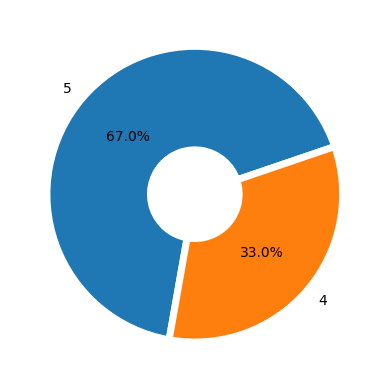



번호를 입력하세요.

1. WAN282X1GB Manual Keyword Frequency
2. WAN282X1GB Manual Contents Keyword Set Review or Score
3. WAN282X1GB Amazon Review Keyword Frequency
4. WAN282X1GB Amazon Review or Score
5. WAN282X1GB Manual Image Extraction
6. Exit

2

        1. Manual Contents Search(목차 리스트만 출력)
        2. Manual Contents Review search(목차와 매칭되는 리뷰 검색)
        2

추출된 목차 키워드 중 검색 가능한 키워드 목록
--------------------------------------------------------------------------------
['appliance', 'care', 'cleaning', 'connection', 'consumption', 'customer', 'damage', 'display', 'energy', 'installation', 'laundry', 'lock', 'material', 'operation', 'protection', 'time']
조회할 키워드를 입력하세요. : time

        
        1. 리뷰 검색
        2. 평점 검색
        
        1
조회할 데이터 개수를 입력하세요.(최대 조회 가능 건수(37건)) : 10
--------------------------------------------------------------------------------


조회한 10건의 조회 결과입니다.
리뷰 작성 날짜 :  2023-04-30

제목 :  Stunning!!!

리뷰 내용 :  Video Player is loading.Play VideoPlayMuteCurrent Time 0:00/Dura

In [ ]:
while True:
    input_var = input('''

번호를 입력하세요.

1. WAN282X1GB Manual Keyword Frequency
2. WAN282X1GB Manual Contents Keyword Set Review or Score
3. WAN282X1GB Amazon Review Keyword Frequency
4. WAN282X1GB Amazon Review or Score
5. WAN282X1GB Manual Image Extraction
6. Exit

''')
    if input_var == '1':
        input_page1 = int(input('조회할 데이터 개수를 입력하세요.(최대 60 개) : '))
        print('=' * 80)
        print(Manual_Keyword_Frequency(document).head(input_page1))
        
    elif input_var == '2':
        contents, contents_len = contents_exteaction(document)
        
        input_contents_number = input("""
        1. Manual Contents Search(목차 리스트만 출력)
        2. Manual Contents Review search(목차와 매칭되는 리뷰 검색)
        """)
        print()
        
        if input_contents_number == '1':
            print(f"총 {contents_len}개의 목차가 검색되었습니다.")
            print('=' * 80)
            print(contents)
            
        elif input_contents_number == '2':
            print('추출된 목차 키워드 중 검색 가능한 키워드 목록')
            print("-" * 80)
            print(contents_review_search(document))
            input_contents_rev_1 = input('조회할 키워드를 입력하세요. : ')
            input_contents_rev_2 = input("""
        
        1. 리뷰 검색
        2. 평점 검색
        
        """)
            
            if input_contents_rev_2 == '1':
                title, sentence, date, star, data_len = Review_All_Search(input_contents_rev_1)

                while True:
                    input_search_option_rv = int(input(f"조회할 데이터 개수를 입력하세요.(최대 조회 가능 건수({data_len}건)) : "))
                    if (input_search_option_rv > data_len):
                        print('최대 조회가능 횟수를 초과하였습니다. 다시 입력하세요. : ')
                    else:
                        break
                        
                print("-" * 80); print("\n")
                print(f"조회한 {input_search_option_rv}건의 조회 결과입니다.")

                for i in range(0, input_search_option_rv):
                    print("=" * 80)
                    print('리뷰 작성 날짜 : ', date[i]); print()
                    print('제목 : ', title[i]); print()
                    print('리뷰 내용 : ', sentence[i]); print()
                    print('평점 : ', star[i])
                    print("=" * 120)

            elif input_contents_rev_2 == '2':
                Crwaling_data_score_vis(input_contents_rev_1)    
                  
            
    elif input_var == '3':
        input_page2 = int(input('조회할 데이터 개수를 입력하세요.(최대 60개) : '))
        print("=" * 80)
        print(Crawling_Text_Data_Keyword_Frequecy(df).head(input_page2))
        
    elif input_var == '4':
        input_data_num = int(input(f'조회할 데이터 개수를 입력하세요.(최대 조회 가능 건수 {len(Manual_Keyword_Search_Score(document))} 건) : '))
        print("=" * 120)
        print(Manual_Keyword_Search_Score(document).head(input_data_num))
        input_page3 = input('조회할 키워드를 입력하세요. : ')
        input_page3_options = input("""
        
        1. 리뷰 검색
        2. 평점 검색
        
        """)
        
        if input_page3_options == '1':
            title, sentence, date, star, data_len = Review_All_Search(input_page3)
            
            while True:
                input_search_option = int(input(f"조회할 데이터 개수를 입력하세요.(최대 조회 가능 건수({data_len}건)) : "))
                if (input_search_option > data_len):
                    print('최대 조회가능 횟수를 초과하였습니다. 다시 입력하세요. : ')
                else:
                    break
            
            print(f"조회한 {input_search_option}건의 조회 결과입니다.")
            print("-" * 80); print("\n")

            for i in range(0, input_search_option):
                print("=" * 80)
                print('리뷰 작성 날짜 : ', date[i]); print()
                print('제목 : ', title[i]); print()
                print('리뷰 내용 : ', sentence[i]); print()
                print('평점 : ', star[i])
                print("=" * 120)

        elif input_page3_options == '2':
            Crwaling_data_score_vis(input_page3)
            
    elif input_var == '5':
        input_image_num_1 = input("""
        
        1. 이미지 출력
        2. 동시출현 키워드 빈도 확인
        
        """)
        
        if input_image_num_1 == '1':
            while True:
                input_image_num_2 = int(input("출력할 이미지 개수를 입력하세요.(최대 13개) : "))
                if (input_image_num_2 > 13):
                    print('최대 조회가능 횟수를 초과하였습니다. 다시 입력하세요. : ')
                else:
                    break
                    
            for i in range(0, input_image_num_2):
                img_color = Image.open(f'manual_{i}.png')
                img_color = np.array(img_color)
                plt.imshow(img_color)
                plt.show()
                print()
                
        elif input_image_num_1 == '2':
            list_im, count_im = Image_compare_review() 
            
            print()
            print(f'이미지에서 추출된 텍스트 목록 : {list_im}')
            print("=" * 80)
            
            if count_im == 0:
                print("매칭되는 리뷰가 존재하지 않습니다.")
            
            else:
                print("매칭되는 리뷰가 존재합니다.")
            
                
    elif input_var == '6':
        break

print("종료되었습니다.")